<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SRAL_waveforms.ipynb"><< SRAL waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_7_SRAL_SWH.ipynb">SRAL significant wave height >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn SRAL: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="1_1_SRAL_data_access_HDA_Data_Store.ipynb" target="_blank">1_1_SRAL_data_access_HDA_Data_Store.ipynb</a>**; this will download the required SRAL products for this notebook.
- **<a href="1_4_SRAL_tracks.ipynb" target="_blank">1_4_SRAL_tracks.ipynb</a>**; to familiarise yourself with the track for the initial plots of this data.
    
</div>
<hr>

# 1.6 SRAL sea surface height anomalies


### Data used

| Product Description  | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:--------:|
| Sentinel-3 SRAL level-2 | EO:EUM:DAT:0415 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___NTC?query=SRAL&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SR_2_WAT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASR_2_WAT___" target="_blank">link</a>|

### Learning outcomes

At the end of this notebook you will know;
* Objective

### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Reading SRAL level-2 SSHA data](#section1)
 1. [Computing corrected sea surface heights & anomalies](#section2)
 1. [Looking at SSHA in dynamics regions: the Agulhas Current and Mozambique Channel](#section2)

<hr>

In [1]:
# library imports
import cartopy
import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.linewidth': 1})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Reading SRAL level-2 SSHA data
[Back to top](#TOC_TOP)

</div>

In [2]:
# selecting SAFE directories
SAFE_directories = [os.path.join(os.getcwd(), 'products', 
    'S3B_SR_2_WAT____20220218T110400_20220218T115102_20220316T035351_2822_062_365______MAR_O_NT_004.SEN3'),
    os.path.join(os.getcwd(), 'products', 
    'S3A_SR_2_WAT____20220101T200835_20220101T205306_20220127T122126_2670_080_213______MAR_O_NT_004.SEN3'),
    os.path.join(os.getcwd(), 'products', 
    'S3A_SR_2_WAT____20220103T063257_20220103T071819_20220128T224727_2722_080_234______MAR_O_NT_004.SEN3')]

measurement_file = "enhanced_measurement.nc"

In [3]:
# read data
ds = xr.open_dataset(os.path.join(SAFE_directories[0], measurement_file))
ds.close()

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Computing corrected sea surface heights & anomalies
[Back to top](#TOC_TOP)

</div>

These are the variables we are going to use:

NB. corrected sea surface height =
                                  Altitude 
                                  - range
                                  - atmosphere propagation corrections (dry/wet troposphere, ionosphere electrons)
                                  - tides (ocean, solid earth and pole)
                                  - atmospheric loading (pressure & hf winds)
                                  - sea state bias

then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (to get sea level anomalies; SLAs) or the geoid (to get absolute dynamic topography; ADT), or nothing (to get SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

Below we define the variables we need to compute a corrected sea surface height and anomalies. The computation here is done with 1 Hz data with corrections dedicated to open ocean; "plrm" variables from a dedicated processing which mimics the conventional altimetry are proposed, but if you use them, use them systematically whenever available. DO NOT MIX PLRM WITH NON PRLM.

Over coastal areas some correction fields would be different, such as the wet tropospheric correction (not from radiometer). Some corrections are only provided at 1Hz, since their resolution can't be higher, but they still must be applied for a computation at 20 Hz, though. So you have to use 20 times the 1 Hz value. 

In [4]:
# need to roll this out to cover all ingested products

# coordinates
lat = ds['lat_01'][:]
lon = ds['lon_01'][:]
alt = ds['alt_01'][:]

# range
range_ku = ds['range_ocean_01_ku'][:]

#atmosphere propagation corrections
model_dry_tropo_corr = ds['mod_dry_tropo_cor_meas_altitude_01'][:]
rad_wet_tropo_corr = ds['rad_wet_tropo_cor_01_ku'][:]
iono_corr_alt_ku = ds['iono_cor_alt_01_ku'][:]

#tides
ocean_tide_sol1 = ds['ocean_tide_sol1_01'][:]
solid_earth_tide = ds['solid_earth_tide_01'][:]
pole_tide = ds['pole_tide_01'][:]

#atmospheric loading, sea state bias
hf_fluctuations_corr = ds['hf_fluct_cor_01'][:]
inv_bar_corr = ds['inv_bar_cor_01'][:]
sea_state_bias_ku = ds['sea_state_bias_01_ku'][:]

#reference surfaces
mean_sea_surface = ds['mean_sea_surf_sol1_01'][:]
mean_topography = ds['mean_dyn_topo_01'] [:]
geoid = ds['geoid_01'] [:]

# surface class flag
surf_class_01 = ds['surf_class_01'][:]
surface_type = ds['surf_type_01'][:]

In [5]:
# applying flags to remove non-ocean values
alt[surface_type != 0.0] = np.nan
range_ku[surface_type != 0.0] = np.nan
iono_corr_alt_ku[surface_type != 0.0] = np.nan
model_dry_tropo_corr[surface_type != 0.0] = np.nan
rad_wet_tropo_corr[surface_type != 0.0] = np.nan
ocean_tide_sol1[surface_type != 0.0] = np.nan
solid_earth_tide[surface_type != 0.0] = np.nan
pole_tide[surface_type != 0.0] = np.nan
hf_fluctuations_corr[surface_type != 0.0] = np.nan
inv_bar_corr[surface_type != 0.0] = np.nan
sea_state_bias_ku[surface_type != 0.0] = np.nan

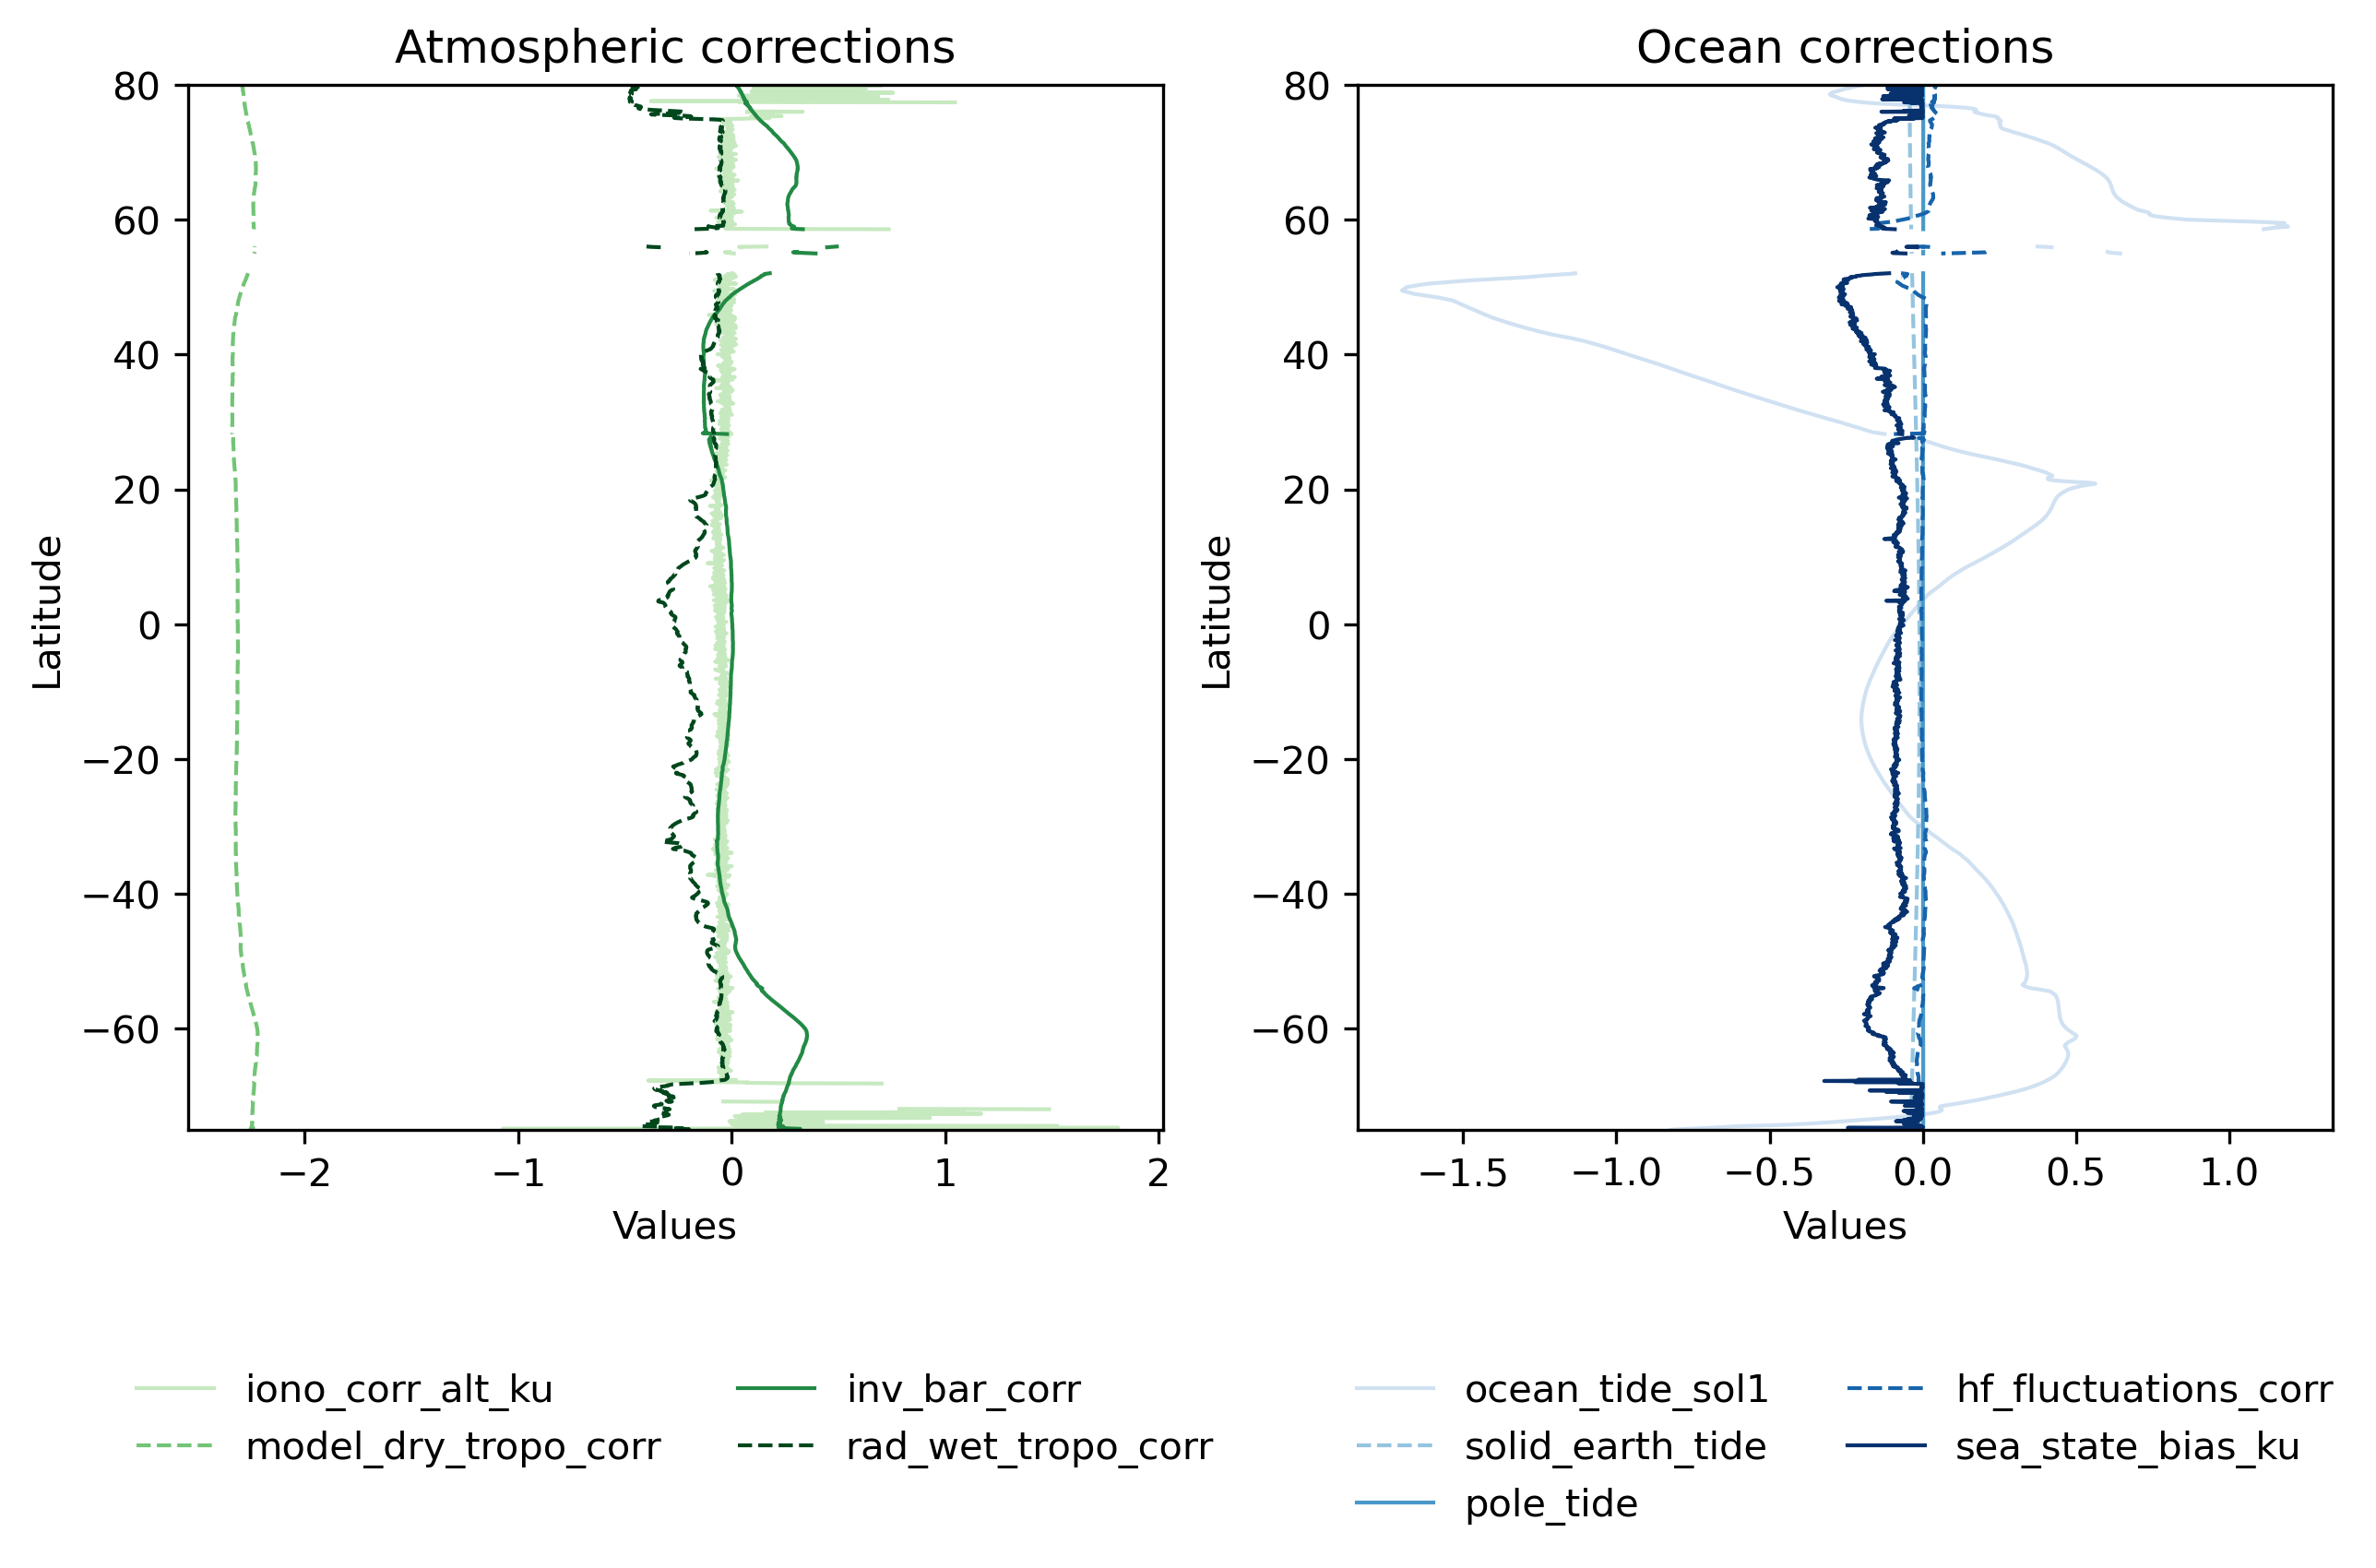

In [6]:
#visualize the variables above
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

cmap = plt.cm.Greens
p1, = axs[0].plot(iono_corr_alt_ku,     lat, c=cmap(0.25), label='iono_corr_alt_ku')
p2, = axs[0].plot(model_dry_tropo_corr, lat, c=cmap(0.50), label='model_dry_tropo_corr', linestyle='--')
p3, = axs[0].plot(inv_bar_corr,         lat, c=cmap(0.75), label='inv_bar_corr')
p4, = axs[0].plot(rad_wet_tropo_corr,   lat, c=cmap(0.99), label='rad_wet_tropo_corr', linestyle='--')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Latitude')
axs[0].set_title("Atmospheric corrections")
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10, frameon=False)
axs[0].set_ylim([-75, 80])

cmap = plt.cm.Blues
p5, = axs[1].plot(ocean_tide_sol1,      lat, c=cmap(0.20), label='ocean_tide_sol1')
p6, = axs[1].plot(solid_earth_tide,     lat, c=cmap(0.40), label='solid_earth_tide', linestyle='--')
p7, = axs[1].plot(pole_tide,            lat, c=cmap(0.60), label='pole_tide')
p8, = axs[1].plot(hf_fluctuations_corr, lat, c=cmap(0.80), label='hf_fluctuations_corr', linestyle='--')
p9, = axs[1].plot(sea_state_bias_ku,    lat, c=cmap(0.99), label='sea_state_bias_ku')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Latitude')
axs[1].set_title("Ocean corrections")
axs[1].set_ylim([-75, 80])

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10, frameon=False)

plt.show()

Here are intermediate computation steps of ssh and ssha (though there is no order to apply the corrections) usually, only the full corrected ones are used, except if e.g. some need to be replaced by local equivalents the idea here is that you get a concrete idea of the impact of each of them

In [7]:
raw_ssh = alt - range_ku
raw_ssha = (alt - range_ku) - mean_sea_surface
ssha_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
ssha_iono_drytropocorr = ssha_ionocorr - model_dry_tropo_corr
ssha_iono_radtropocorr = ssha_iono_drytropocorr - rad_wet_tropo_corr
tides = ocean_tide_sol1 + solid_earth_tide + pole_tide
ssha_iono_tropo_tides_corr = ssha_iono_radtropocorr - tides
ssha_iono_tropo_tides_ssb_corr = ssha_iono_tropo_tides_corr - sea_state_bias_ku
dynatmcorr = hf_fluctuations_corr + inv_bar_corr
ssha_fullcorr = ssha_iono_tropo_tides_ssb_corr - dynatmcorr
adt = ssha_fullcorr + mean_topography

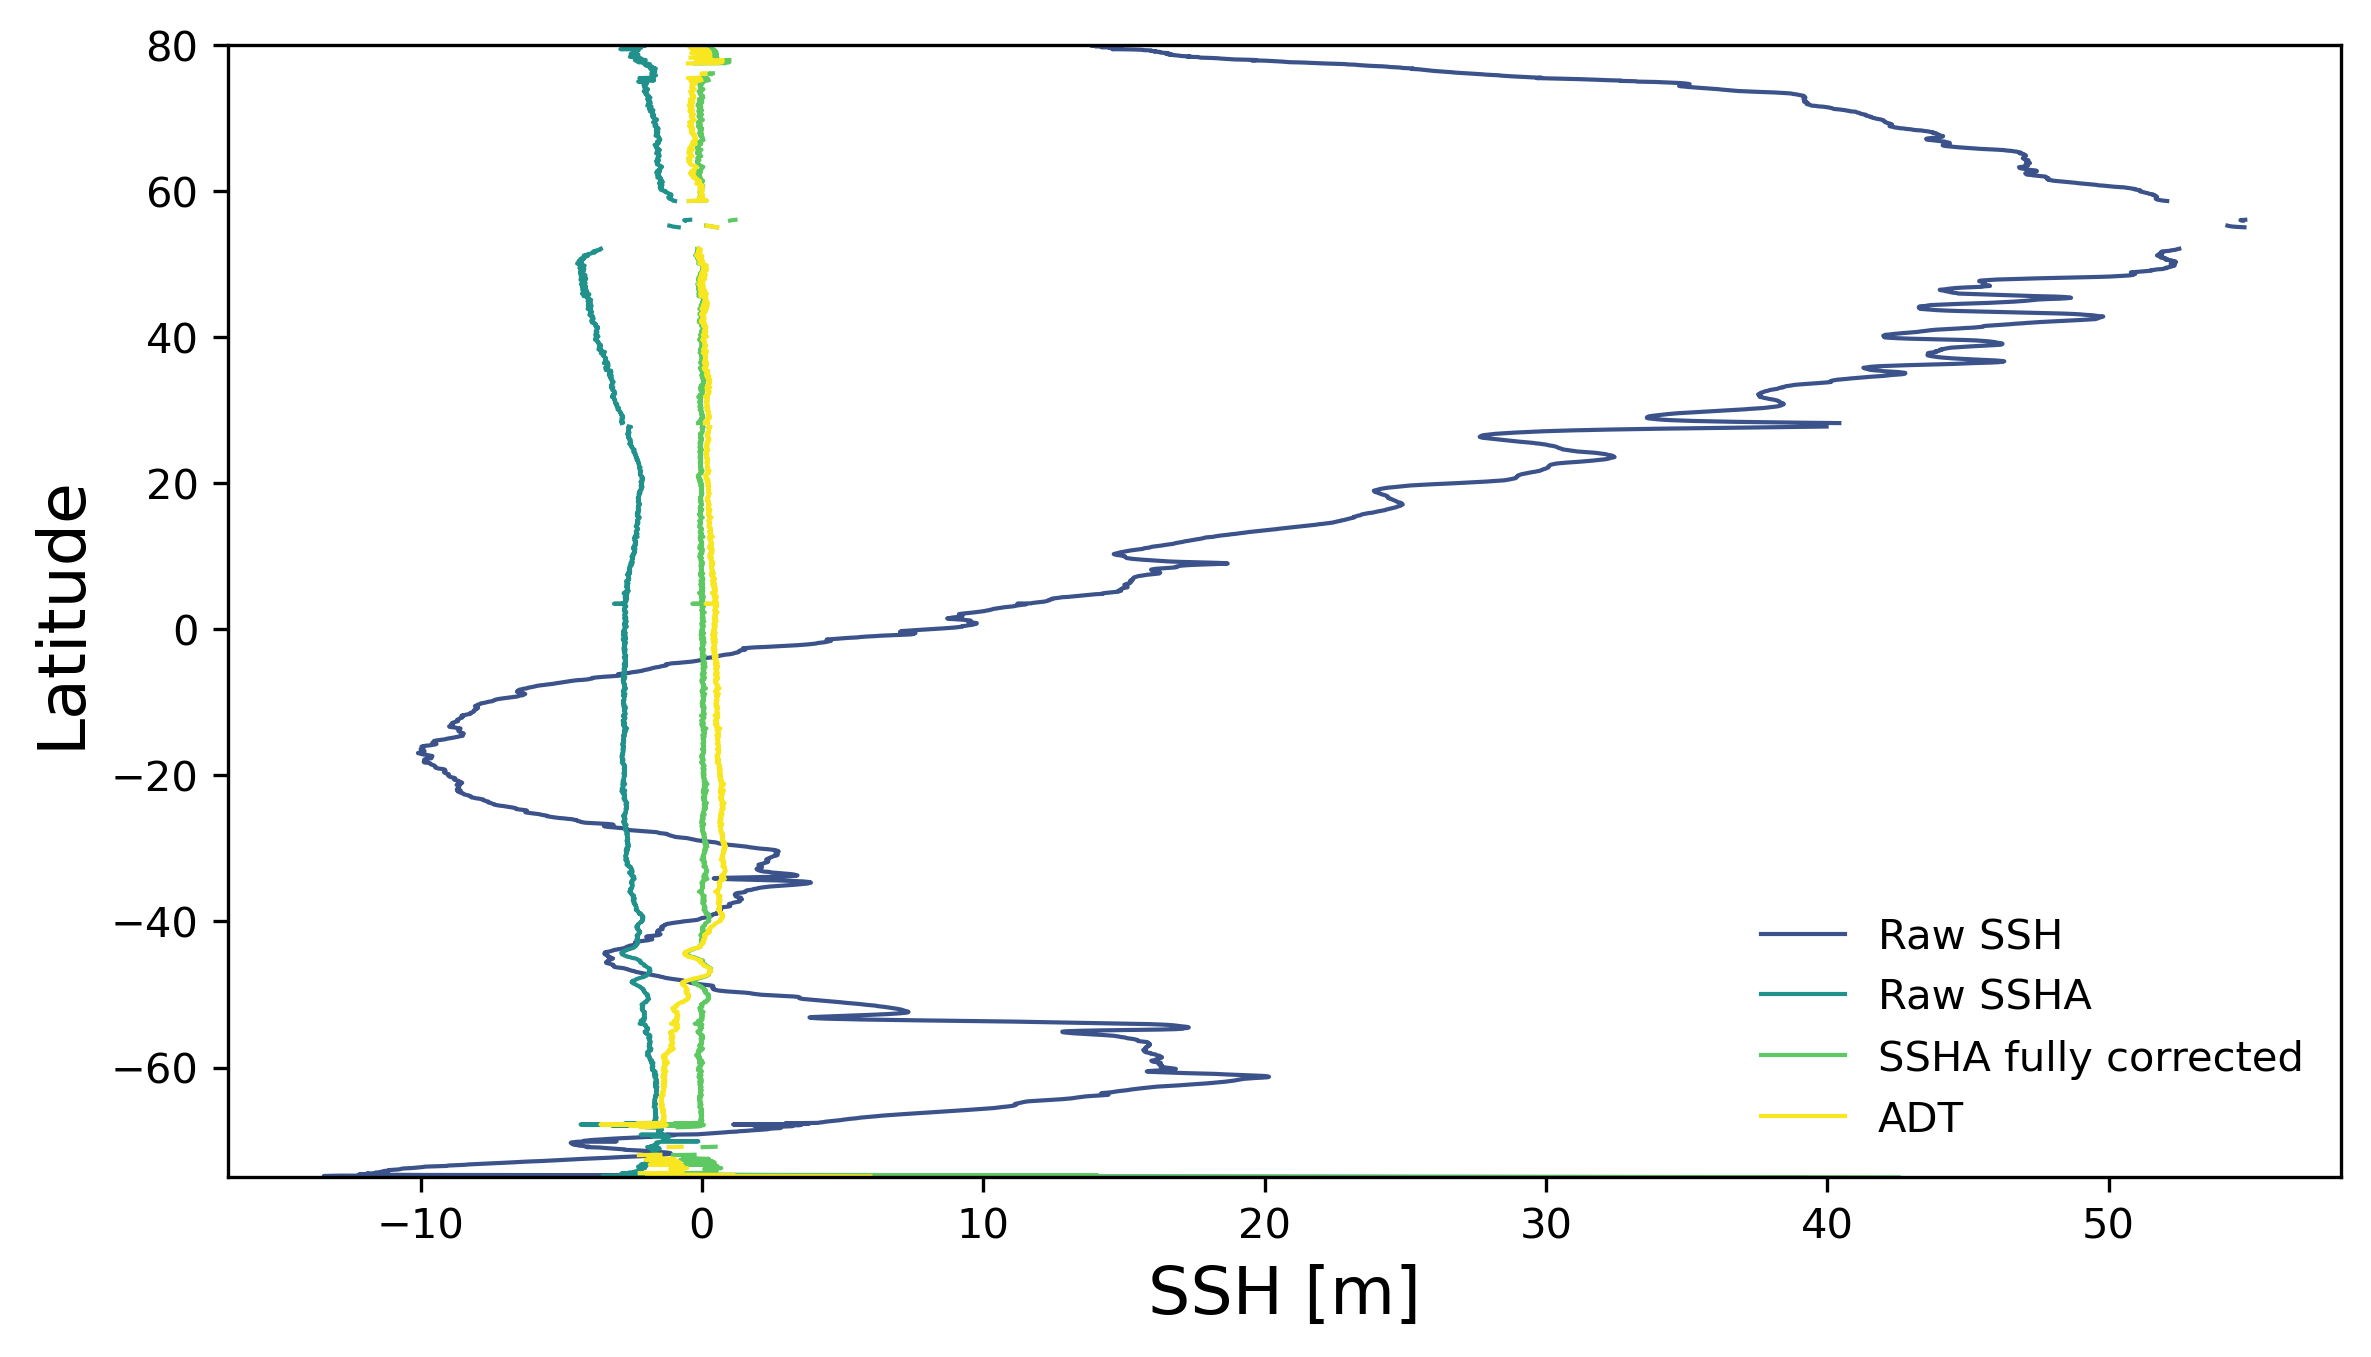

In [8]:
#plot e.g. a "raw" version of SSH (un-corrected) and the corrected ssha
fig1 = plt.figure(figsize=(20, 5), dpi=300)
ax = plt.subplot(1,2,1)
cmap = plt.cm.viridis
p1, = ax.plot(raw_ssh, lat, c=cmap(0.25), label='Raw SSH')
p2, = ax.plot(raw_ssha, lat, c=cmap(0.50), label='Raw SSHA')
p3, = ax.plot(ssha_fullcorr, lat, c=cmap(0.75), label='SSHA fully corrected')
p4, = ax.plot(adt, lat, c=cmap(0.99), label='ADT')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False)
ax.set_ylim([-75, 80])
ax.set_xlabel('SSH [m]', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
plt.show()

Note the amplitude of the SSH, and note also the very extreme SSH data (not present in the corrected SLA)

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Looking at SSHA in dynamic regions: the Agulhas Current and Mozambique Channel
[Back to top](#TOC_TOP)

</div>

In [9]:
# read data
ds1 = xr.open_dataset(os.path.join(SAFE_directories[1], measurement_file))
ds1.close()

# read data
ds2 = xr.open_dataset(os.path.join(SAFE_directories[2], measurement_file))
ds2.close()

# read data
ds3 = xr.open_dataset(os.path.join('products', 'dataset-duacs-nrt-global-merged-allsat-phy-l4.nc'))
ds3.close()

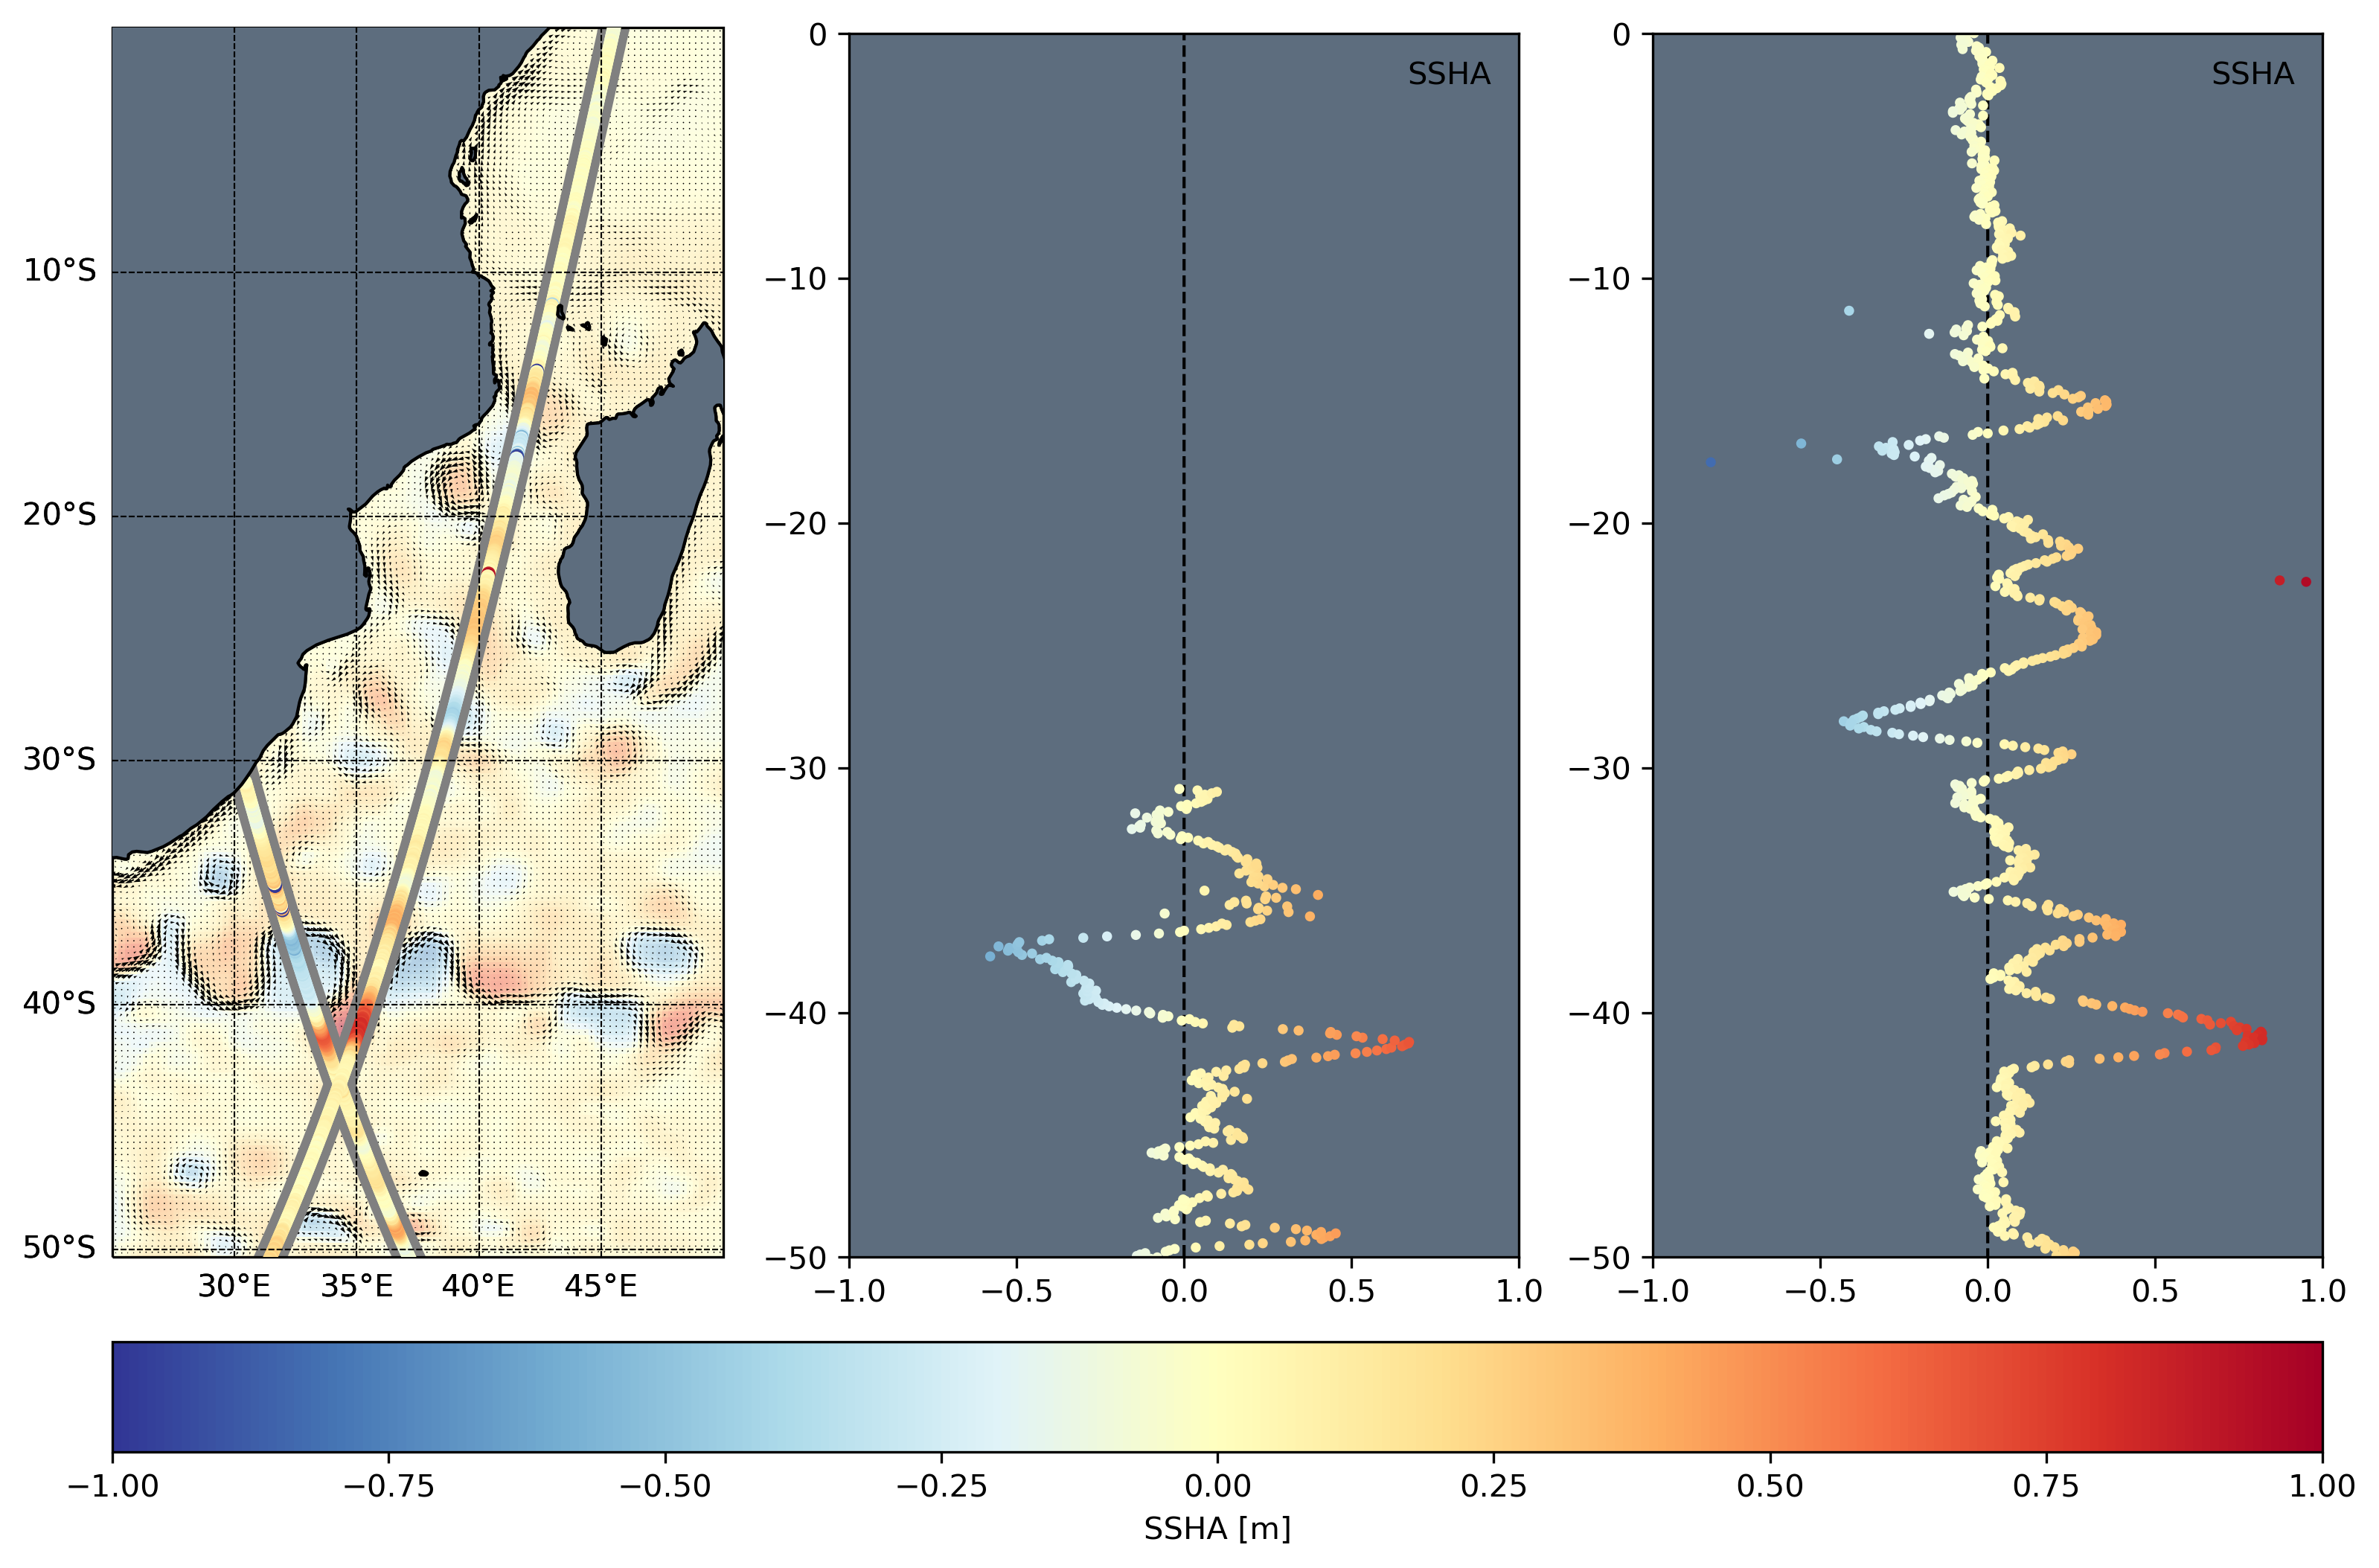

In [10]:
fig = plt.figure(figsize=(12, 10), dpi=300)
axs = [plt.subplot(131, projection=cartopy.crs.PlateCarree()),
       plt.axes([0.4, 0.125, 0.25, 0.685]),
       plt.axes([0.7, 0.125, 0.25, 0.685])]

cmap = plt.cm.RdYlBu_r

lon_vars = [ds1.lon_01, ds2.lon_01]
lat_vars = [ds1.lat_01, ds2.lat_01]
plot_vars = [ds1.ssha_01_ku, ds2.ssha_01_ku]

axs[0].pcolormesh(ds3["longitude"], ds3["latitude"], ds3["sla"][0,:,:], vmin=-1, vmax=1,
                  cmap=cmap, zorder=1, alpha=0.5)
axs[0].quiver(ds3["longitude"], ds3["latitude"], ds3["ugos"][0,:,:], ds3["vgos"][0,:,:])

for lon, lat, plot_var in zip(lon_vars, lat_vars, plot_vars):
    f1 = axs[0].plot(lon, lat, '0.5', zorder=2, linewidth=10)
        
    f1 = axs[0].scatter(lon, lat, c=plot_var, cmap=cmap, 
                   s=20, marker='o', edgecolors=None, linewidth=0.0, zorder=3, vmin=-1, vmax=1)
    
    axs[0].add_feature(cartopy.feature.LAND, zorder=4, edgecolor='k', facecolor='#5D6D7E')
    g1 = axs[0].gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    axs[0].set(facecolor = "1.0")
    axs[0].set_extent([25, 50, -50, 0])       

cbar = plt.colorbar(f1, ax=axs, orientation="horizontal", pad=0.05)
cbar.set_label('SSHA [m]')

for ax, lat, plot_var, ds in zip([axs[1], axs[2]], lat_vars, plot_vars, [ds1, ds2]):

    flags_ssha = np.array(ds.range_ocean_qual_01_ku).astype(float) \
           + np.array(ds.surf_class_01).astype(float) \
           + np.array(ds.rad_surf_type_01).astype(float)
    plot_var[flags_ssha != 0] = np.nan

    p1 = ax.scatter(plot_var, lat, c=plot_var, cmap=cmap, s=5, label='SSHA', vmin=-1, vmax=1, zorder=1)
    p2 = ax.plot(lat*0, lat, 'k--', zorder=0)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False)
    ax.set_ylim([-50, 0])
    ax.set_xlim([-1, 1])
    ax.set(facecolor = "#5D6D7E")

plt.savefig('1_6_SRAL_SSHA.png')

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SRAL_waveforms.ipynb"><< SRAL waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_7_SRAL_SWH.ipynb">SRAL significant wave height >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>